<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/4_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [9]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 145 (delta 74), reused 94 (delta 32), pack-reused 0
Receiving objects: 100% (145/145), 31.79 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/cloned-repo/cloned-repo
1_NASA_FD001_EDA.ipynb			   5_XGBoost.ipynb
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data
4_RandomForest.ipynb			   README.md


In [10]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_test.csv')

In [11]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

### **Train RandomForest**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [13]:
RndFor = RandomForestClassifier(random_state=42)

#### **GridSearch**

Since we are doing a multiclass evaluation, we will have to define our scoring strategy that aligns with our business objective. In our case, we are interested in the recall. We will use the "weighted" average to account for class imbalance which works by computing the average metrics where each class's score is weighted by its presence in the true data sample.  
[Scikit-Learn Reference](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring)

In [14]:
"""
param_dict = {
    'class_weight':['balanced', 'balanced_subsample'],
    'n_estimators':range(100,500,50),
}
"""

"\nparam_dict = {\n    'class_weight':['balanced', 'balanced_subsample'],\n    'n_estimators':range(100,500,50),\n}\n"

In [15]:
# Define scoring strategy
weighted_recall = make_scorer(recall_score, average='weighted')

In [16]:
"""
RndForGrid = GridSearchCV(RndFor,
                          param_grid=param_dict,
                          cv=5,
                          scoring=weighted_recall,
                          verbose=1,
                          n_jobs=-1)
RndForGrid.fit(X_train, y_train)
"""

'\nRndForGrid = GridSearchCV(RndFor,\n                          param_grid=param_dict,\n                          cv=5,\n                          scoring=weighted_recall,\n                          verbose=1,\n                          n_jobs=-1)\nRndForGrid.fit(X_train, y_train)\n'

In [17]:
#RndForGrid.best_params_

In [18]:
# Store the best parameters
#RndForBest = RndForGrid.best_estimator_

#### **Best Tree From GridSearch**  
Best Parameters from GridSearch:  
*  n_estimators: 350  
*  class_weight: balanced
  
We stored our parameters under the RndForBest variable, but we will train our best model below so we don't have to run the GridSearch again.

In [19]:
RndForBest = RandomForestClassifier(n_estimators=350, class_weight='balanced', random_state=42)

#### **Random Forest Evaluation**

In [ ]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 7.9MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


##### **Classification Report**

In [ ]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

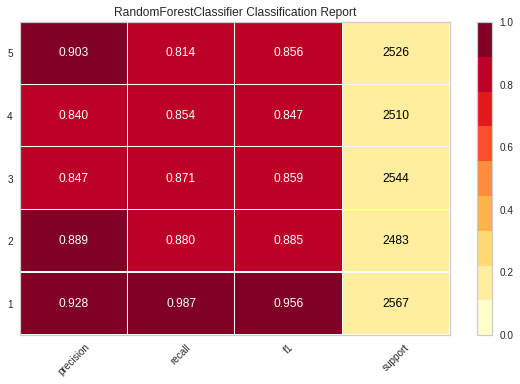

In [ ]:
viz = ClassificationReport((RndForBest), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

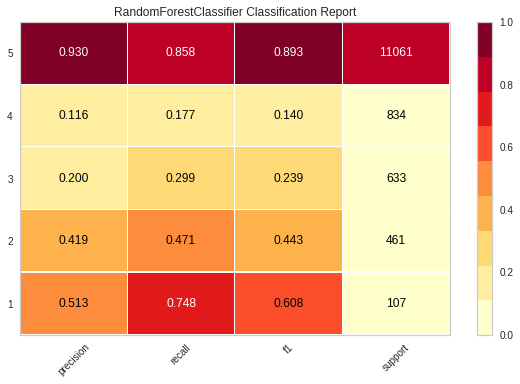

In [ ]:
viz = ClassificationReport((RndForBest), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **ROC-AUC Receiver Operating Characteristic**

In [ ]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

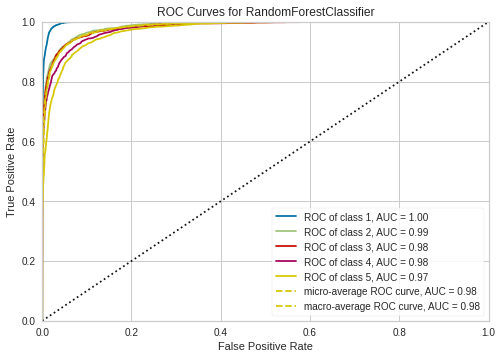

In [ ]:
model = RndForBest
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

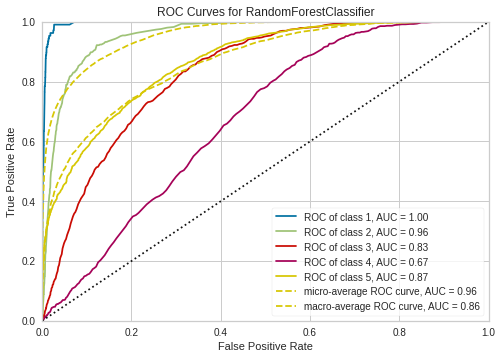

In [ ]:
model = RndForBest
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

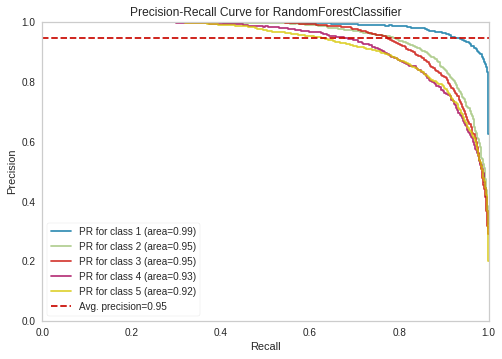

In [ ]:
viz = PrecisionRecallCurve((RndForBest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

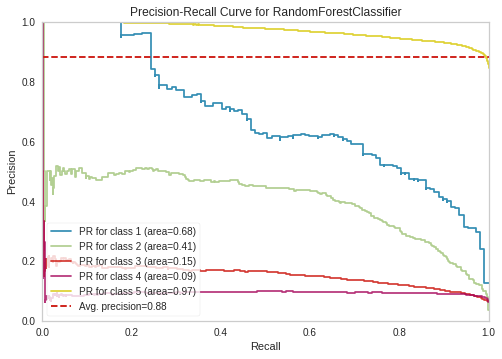

In [ ]:
viz = PrecisionRecallCurve((RndForBest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [ ]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**  
Had to convert y_val to 1D array

In [ ]:
y_val = y_val.to_numpy()

In [ ]:
y_val = y_val.flatten()

In [ ]:
y_val.ndim

1

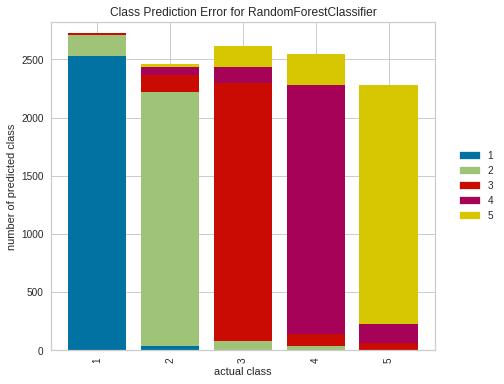

In [ ]:
viz = ClassPredictionError((RndForBest), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [ ]:
y_test = y_test.to_numpy()

In [ ]:
y_test = y_test.flatten()

In [ ]:
y_test.ndim

1

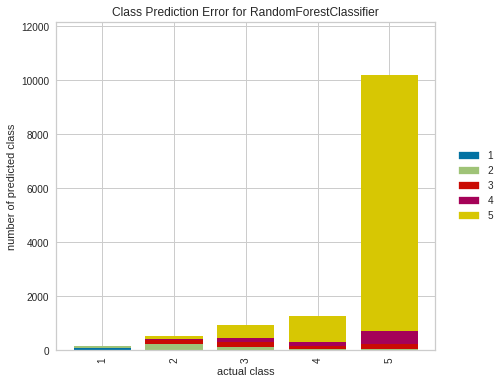

In [ ]:
viz = ClassPredictionError(RndForBest)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

**Validation Set**

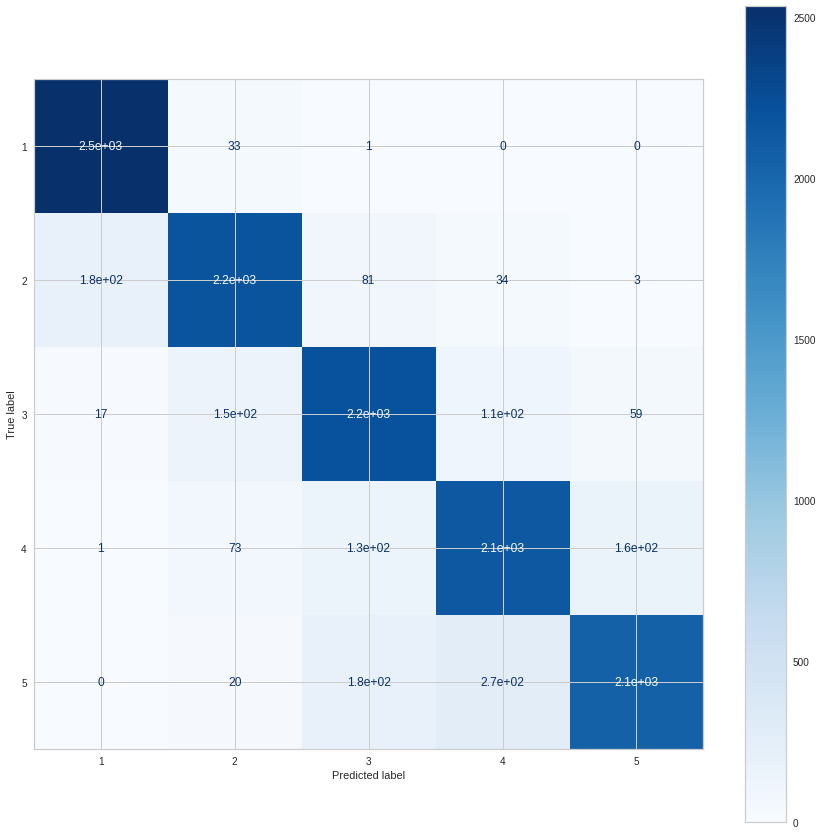

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(RndForBest, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

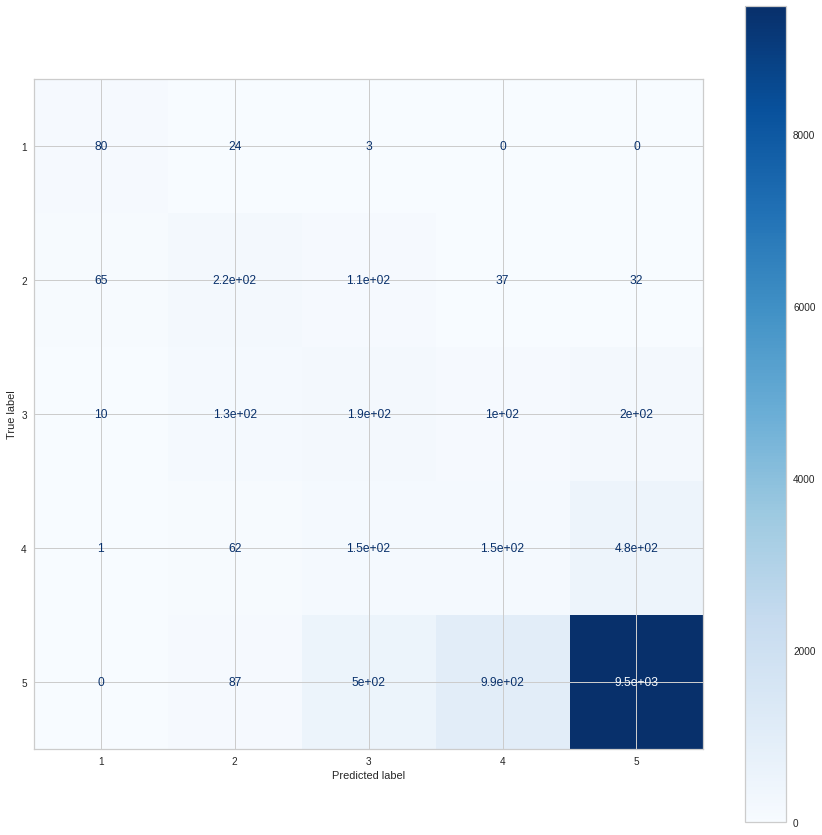

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(RndForBest, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

## **Save Model**

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
import joblib

In [23]:
model_save_name = '5_class_randomforest'
path = F"/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/{model_save_name}"
joblib.dump(RndForBest, path)

['/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_randomforest']

In [25]:
RndForBest = joblib.load('/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_randomforest')

In [26]:
RndForBest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### **Results**  
By changing the class weights to represent the class imbalance, we increased the ROC-AUC by 1%, increasing the average precision by 2% with a decrease in PR for class 1 of 1%.  Our F1 score also improved by 2.6%. This isn't much of an improvement, but it gave us some insights to apply going forward.

### **Results**  

When comparing our RandomForest model to the previous DecisionTree model, we observed:
*  8% increase in precision
*  6.5% decrease in recall
*  4.3% increase in F1
*  27% increase in Precision-Recall curve area 
   
When looking at the confusion matrices of the two models, we observed:
*  27 late predictions for the RandomForest
*  20 late predictions  for the DecisionTree
